[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=a2876e19c8a62fc457049c0ff2307f817bfd72f0e397f89b0ecda204975a206a
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [2]:
import wget 

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers.zip'

In [3]:
import zipfile

with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [4]:
import os 

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['daisy', 'tulip', 'sunflower', 'rose', 'dandelion']

In [5]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: daisy. Imágenes: 769
Categoría: tulip. Imágenes: 984
Categoría: sunflower. Imágenes: 734
Categoría: rose. Imágenes: 784
Categoría: dandelion. Imágenes: 1055


In [6]:
imgs[:5]
len(imgs)

4323

Podemos visualizar algunas imágenes en el dataset.

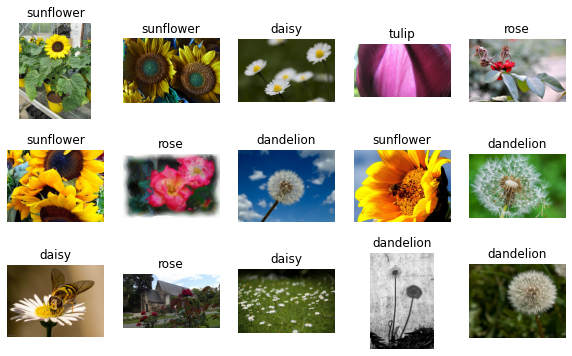

In [7]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [8]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(3458, 865)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [9]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [10]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(3458, 865)

In [11]:
dataset['train'][2]

(tensor([[[0.1137, 0.0863, 0.0588,  ..., 0.6706, 0.4863, 0.3569],
          [0.1098, 0.1020, 0.0863,  ..., 0.7020, 0.5373, 0.3804],
          [0.1059, 0.1333, 0.1255,  ..., 0.7294, 0.6078, 0.3961],
          ...,
          [0.1647, 0.1451, 0.1098,  ..., 0.0902, 0.0431, 0.0196],
          [0.1725, 0.1333, 0.0980,  ..., 0.0510, 0.0353, 0.0235],
          [0.1686, 0.1216, 0.0941,  ..., 0.0431, 0.0392, 0.0157]],
 
         [[0.2431, 0.2157, 0.1686,  ..., 0.7294, 0.6039, 0.4980],
          [0.2392, 0.2314, 0.2196,  ..., 0.7569, 0.6353, 0.5216],
          [0.2392, 0.2627, 0.2627,  ..., 0.7647, 0.6941, 0.5373],
          ...,
          [0.3176, 0.3059, 0.2784,  ..., 0.1725, 0.1020, 0.0824],
          [0.3255, 0.2941, 0.2549,  ..., 0.1490, 0.1137, 0.0863],
          [0.3255, 0.2824, 0.2392,  ..., 0.1529, 0.1333, 0.0863]],
 
         [[0.1765, 0.1412, 0.1020,  ..., 0.8392, 0.6941, 0.5176],
          [0.1647, 0.1569, 0.1412,  ..., 0.8588, 0.7569, 0.5843],
          [0.1647, 0.1882, 0.1843,  ...,

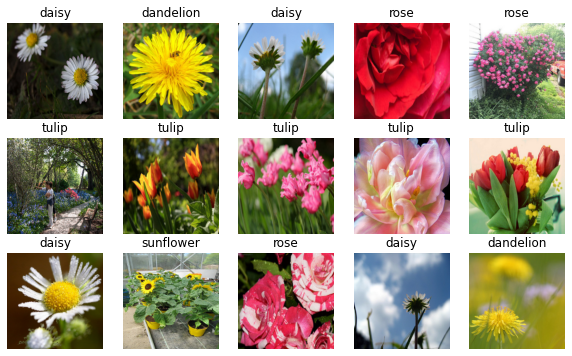

In [12]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [13]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [14]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [16]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 5])

In [17]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [18]:
model_c = ModelCustom()
fit(model_c, dataloader, epochs=15)

val_loss 1.80979 val_acc 0.24884: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 1/15 loss 1.37130 val_loss 1.80979 acc 0.40881 val_acc 0.24884


val_loss 7.05681 val_acc 0.21596: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Epoch 2/15 loss 1.15053 val_loss 7.05681 acc 0.53267 val_acc 0.21596


val_loss 4.00236 val_acc 0.33443: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 3/15 loss 1.05518 val_loss 4.00236 acc 0.58295 val_acc 0.33443


val_loss 4.16422 val_acc 0.27732: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 4/15 loss 0.95515 val_loss 4.16422 acc 0.62955 val_acc 0.27732


val_loss 16.92053 val_acc 0.16436: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 5/15 loss 0.91858 val_loss 16.92053 acc 0.63835 val_acc 0.16436


val_loss 4.16065 val_acc 0.26916: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 6/15 loss 0.87131 val_loss 4.16065 acc 0.66705 val_acc 0.26916


val_loss 1.88104 val_acc 0.43274: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 7/15 loss 0.79684 val_loss 1.88104 acc 0.69972 val_acc 0.43274


val_loss 1.25622 val_acc 0.55866: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 8/15 loss 0.75434 val_loss 1.25622 acc 0.70511 val_acc 0.55866


val_loss 4.27448 val_acc 0.34482: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 9/15 loss 0.70234 val_loss 4.27448 acc 0.72188 val_acc 0.34482


val_loss 4.69472 val_acc 0.27627: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 10/15 loss 0.69399 val_loss 4.69472 acc 0.73636 val_acc 0.27627


val_loss 8.65255 val_acc 0.24892: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 11/15 loss 0.66444 val_loss 8.65255 acc 0.75511 val_acc 0.24892


val_loss 1.65524 val_acc 0.51594: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 12/15 loss 0.63345 val_loss 1.65524 acc 0.76932 val_acc 0.51594


val_loss 5.74081 val_acc 0.32751: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 13/15 loss 0.59338 val_loss 5.74081 acc 0.77699 val_acc 0.32751


val_loss 1.92394 val_acc 0.41348: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 14/15 loss 0.58862 val_loss 1.92394 acc 0.77244 val_acc 0.41348


val_loss 5.74084 val_acc 0.30291: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

Epoch 15/15 loss 0.56912 val_loss 5.74084 acc 0.78580 val_acc 0.30291


Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [19]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

val_loss 1.02887 val_acc 0.56523: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 1/5 loss 1.07884 val_loss 1.02887 acc 0.62500 val_acc 0.56523


val_loss 1.11759 val_acc 0.50672: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 2/5 loss 0.67729 val_loss 1.11759 acc 0.79716 val_acc 0.50672


val_loss 1.01292 val_acc 0.58956: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 3/5 loss 0.56342 val_loss 1.01292 acc 0.82188 val_acc 0.58956


val_loss 0.65036 val_acc 0.75553: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 4/5 loss 0.51186 val_loss 0.65036 acc 0.83722 val_acc 0.75553


val_loss 0.58831 val_acc 0.77150: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

Epoch 5/5 loss 0.44845 val_loss 0.58831 acc 0.86619 val_acc 0.77150


Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [20]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 0.75162 val_acc 0.68893: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 1/5 loss 0.80721 val_loss 0.75162 acc 0.72756 val_acc 0.68893


val_loss 0.71564 val_acc 0.73459: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 2/5 loss 0.38503 val_loss 0.71564 acc 0.87813 val_acc 0.73459


val_loss 0.40162 val_acc 0.85001: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 3/5 loss 0.27980 val_loss 0.40162 acc 0.90824 val_acc 0.85001


val_loss 0.43077 val_acc 0.84451: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 4/5 loss 0.19510 val_loss 0.43077 acc 0.94432 val_acc 0.84451


val_loss 0.26062 val_acc 0.91422: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

Epoch 5/5 loss 0.15077 val_loss 0.26062 acc 0.95653 val_acc 0.91422


Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [21]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

val_loss 2.00207 val_acc 0.19616: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 1/5 loss 1.06140 val_loss 2.00207 acc 0.63040 val_acc 0.19616


val_loss 0.74889 val_acc 0.71006: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 2/5 loss 0.66812 val_loss 0.74889 acc 0.79716 val_acc 0.71006


val_loss 0.77258 val_acc 0.69460: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 3/5 loss 0.54291 val_loss 0.77258 acc 0.82727 val_acc 0.69460


val_loss 0.51943 val_acc 0.81556: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Epoch 4/5 loss 0.48293 val_loss 0.51943 acc 0.85682 val_acc 0.81556


val_loss 0.97515 val_acc 0.60307: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 5/5 loss 0.45420 val_loss 0.97515 acc 0.85653 val_acc 0.60307


val_loss 0.82117 val_acc 0.67482: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Epoch 1/5 loss 0.96188 val_loss 0.82117 acc 0.62301 val_acc 0.67482


val_loss 0.64071 val_acc 0.75181: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 2/5 loss 0.70770 val_loss 0.64071 acc 0.71591 val_acc 0.75181


val_loss 0.54371 val_acc 0.79798: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 3/5 loss 0.59164 val_loss 0.54371 acc 0.78892 val_acc 0.79798


val_loss 0.47616 val_acc 0.83040: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 4/5 loss 0.50005 val_loss 0.47616 acc 0.81847 val_acc 0.83040


val_loss 0.45680 val_acc 0.84407: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

Epoch 5/5 loss 0.46333 val_loss 0.45680 acc 0.84688 val_acc 0.84407


Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [23]:
optimizer = torch.optim.Adam([
    {'params': model_o.resnet.parameters(), 'lr': 1e-4},
    {'params': model_o.fc.parameters(), 'lr': 1e-3}
])

In [24]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    model.to(device)
    optimizer = optimizer = torch.optim.Adam([{'params': model.resnet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [25]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)
model_o.unfreeze()
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.62565 val_acc 0.81361: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Epoch 1/5 loss 0.98533 val_loss 0.62565 acc 0.64659 val_acc 0.81361


val_loss 0.48605 val_acc 0.84735: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 2/5 loss 0.55967 val_loss 0.48605 acc 0.83210 val_acc 0.84735


val_loss 0.44392 val_acc 0.85091: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 3/5 loss 0.47016 val_loss 0.44392 acc 0.85000 val_acc 0.85091


val_loss 0.40842 val_acc 0.86618: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 4/5 loss 0.42787 val_loss 0.40842 acc 0.86136 val_acc 0.86618


val_loss 0.39425 val_acc 0.84993: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 5/5 loss 0.41702 val_loss 0.39425 acc 0.86761 val_acc 0.84993


val_loss 0.21976 val_acc 0.92559: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 1/5 loss 0.29446 val_loss 0.21976 acc 0.89545 val_acc 0.92559


val_loss 0.19785 val_acc 0.93766: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 2/5 loss 0.06749 val_loss 0.19785 acc 0.98040 val_acc 0.93766


val_loss 0.20871 val_acc 0.93180: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Epoch 3/5 loss 0.06766 val_loss 0.20871 acc 0.98153 val_acc 0.93180


val_loss 0.22157 val_acc 0.92567: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 4/5 loss 0.05713 val_loss 0.22157 acc 0.98040 val_acc 0.92567


val_loss 0.20045 val_acc 0.93340: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

Epoch 5/5 loss 0.04706 val_loss 0.20045 acc 0.98892 val_acc 0.93340


## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.